In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 94% 204M/218M [00:01<00:00, 186MB/s]
100% 218M/218M [00:01<00:00, 179MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-and-dog.zip', 'r')
zip_ref.extractall('data')
zip_ref.close()

In [4]:
#importing all the necessary library
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
from keras import regularizers

In [6]:
#defining the train and validation data
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/data/test_set/test_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/data/test_set/test_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224)
)

Found 2023 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [7]:
#normalizing the data
def normalize(image, label):
  image = tf.cast(image, tf.float32)/255
  return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

In [8]:
#this code help us to store the training performance in cache so that model has not to wait very long to again perform the test on another epochs
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
#introducing vgg16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
#freezing the conv layer
conv_base.trainable = False

In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
#fully connected layer architecture
model = Sequential()
model.add(conv_base)
model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import EarlyStopping

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
64/64 [==============================] - 76s 1s/step - loss: 1.1377 - accuracy: 0.7281 - val_loss: 0.5855 - val_accuracy: 0.9155
Epoch 2/10
64/64 [==============================] - 75s 1s/step - loss: 0.5993 - accuracy: 0.8636 - val_loss: 0.4335 - val_accuracy: 0.9451
Epoch 3/10
64/64 [==============================] - 75s 1s/step - loss: 0.4584 - accuracy: 0.9051 - val_loss: 0.3244 - val_accuracy: 0.9664
Epoch 4/10
64/64 [==============================] - 75s 1s/step - loss: 0.3832 - accuracy: 0.9268 - val_loss: 0.2861 - val_accuracy: 0.9679
Epoch 5/10
64/64 [==============================] - 75s 1s/step - loss: 0.3524 - accuracy: 0.9303 - val_loss: 0.2544 - val_accuracy: 0.9847
Epoch 6/10
64/64 [==============================] - 76s 1s/step - loss: 0.3488 - accuracy: 0.9189 - val_loss: 0.3735 - val_accuracy: 0.9041
Epoch 7/10
64/64 [==============================] - 76s 1s/step - loss: 0.3638 - accuracy: 0.9259 - val_loss: 0.2167 - val_accuracy: 0.9797
Epoch 8/10
64/64 [==

In [18]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

64/64 [==============================] - 37s 585ms/step - loss: 0.2145 - accuracy: 0.9787
Test Loss: 0.2145111858844757
Test Accuracy: 0.9787444472312927


In [20]:
import numpy as np
from sklearn.metrics import classification_report

# Making predictions on the test dataset
y_pred_probs = model.predict(val_ds)

y_pred = np.where(y_pred_probs > 0.5, 1, 0)

y_true = np.concatenate([y for x, y in val_ds], axis=0)

64/64 [==============================] - 37s 572ms/step


In [21]:
#classification report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98      1011
     Class 1       0.99      0.97      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



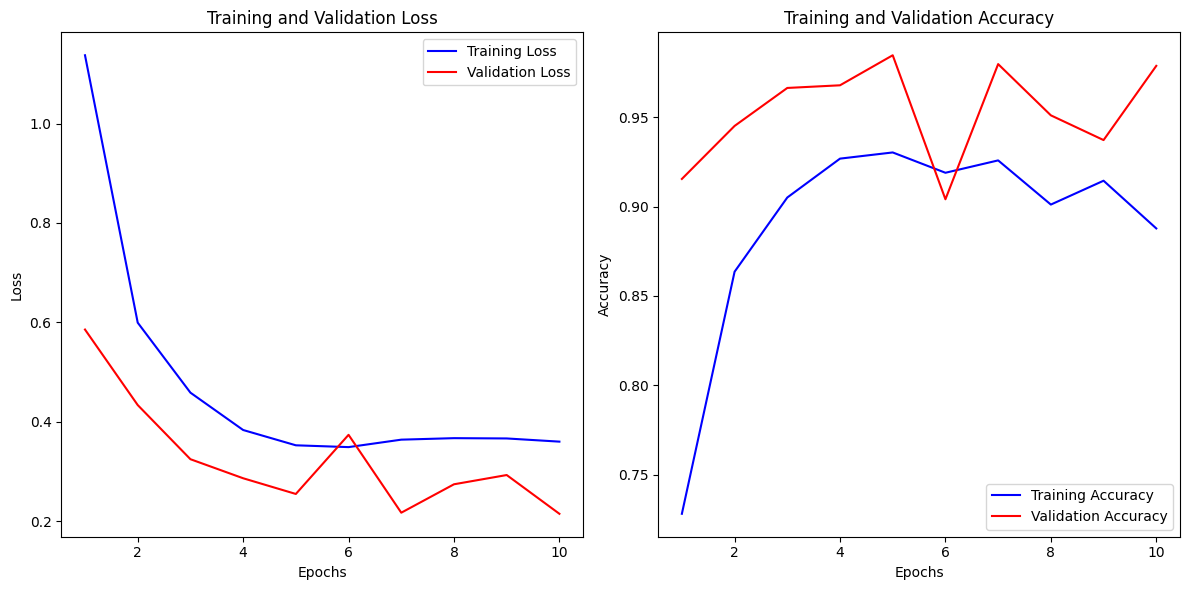

In [22]:
import matplotlib.pyplot as plt

#training history data
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/dogimg.jpg'
img = image.load_img(img_path, target_size=(224, 224))  #size matches model's input

# Converting the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

#normalizing
img_array /= 255.0

In [24]:
# Predicting the class (1 for dog, 0 for cat)
predictions = model.predict(img_array)
if predictions[0] > 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 202ms/step
It's a dog!


In [25]:
img_path = '/catimg.jpg'
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

In [27]:

prediction = model.predict(img_array)

if prediction[0] > 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 78ms/step
It's a cat!


In [29]:
img_path1 = '/cati.jpg'
img1 = image.load_img(img_path1, target_size=(224, 224))

img_array1 = image.img_to_array(img1)

img_array1 = np.expand_dims(img_array1, axis=0)

img_array1 /= 255.0

In [30]:

prediction1 = model.predict(img_array1)

if prediction1[0] > 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 76ms/step
It's a cat!


In [31]:
prediction1

array([[1.192832e-08]], dtype=float32)

## The final accuracy of this model is given above in a confusion matric where the overall accuracy of a model is 0.98 and precision, recall and f1-score is also 0.97, 0.99 and 0.98

## first of all i preporcessed the data then spiltted it to train and validation then imported vgg16 for transfer learning then i removed the flatten layer from vgg16 and then i freezed the vgg16 convolution layer from training because it is already trained by professionals so there's no need to train it again. then i defined the full layer architecture by myself where i used relu as an activation function and l2 kernel regularization to prevent model from getting overfit. and then i performed the model training as you can see the model is slightly underfitting but it is working very well on unseen data as i have performed model test where it is predicting very well not once misclasiification has been done so I guess model is performing very well.